In [1]:
import os
import sys

# Check if running in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab")
    # Mount Google Drive for saving results
    from google.colab import drive

    drive.mount('/content/drive')

    # Create output directories in Colab
    os.makedirs('/content/data/images', exist_ok=True)
    os.makedirs('/content/data/labels', exist_ok=True)
    os.makedirs('/content/results', exist_ok=True)
else:
    print("Running in local environment")
    # Create local directories
    os.makedirs('data/images', exist_ok=True)
    os.makedirs('data/labels', exist_ok=True)
    os.makedirs('results', exist_ok=True)

# Define base paths based on environment
if IN_COLAB:
    BASE_PATH = '/content'
    DRIVE_PATH = '/content/drive/MyDrive/22001534/ComputerVision/Lab5'
    # Create folder in Drive to save results
    os.makedirs(DRIVE_PATH, exist_ok=True)
else:
    BASE_PATH = '.'

print(f"Base path: {BASE_PATH}")

Running in Google Colab
Mounted at /content/drive
Base path: /content


## 1. Setup & Dependencies

In [2]:
# Install packages
!pip install torch torchvision torchaudio --quiet
!pip install pycocotools opencv-python matplotlib seaborn scikit-learn --quiet
!pip install requests tqdm pillow --quiet
!pip install roboflow --quiet  # For downloading Panda dataset

import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import requests
from tqdm import tqdm
from typing import List, Tuple
import zipfile
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Set seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directories
os.makedirs('data/images', exist_ok=True)
os.makedirs('data/labels', exist_ok=True)
os.makedirs('results', exist_ok=True)


def channel_shuffle(x: torch.Tensor, groups: int) -> torch.Tensor:
    if groups <= 1:
        return x
    b, c, h, w = x.shape
    assert c % groups == 0, "channels must be divisible by groups"
    x = x.view(b, groups, c // groups, h, w)
    x = x.transpose(1, 2).contiguous()
    x = x.view(b, c, h, w)
    return x


class ConvBNAct(nn.Module):
    def __init__(self, c_in, c_out, k=3, s=1, p=None, g=1, act=True):
        super().__init__()
        if p is None:
            p = (k - 1) // 2
        self.conv = nn.Conv2d(c_in, c_out, k, s, p, groups=g, bias=False)
        self.bn = nn.BatchNorm2d(c_out)
        self.act = nn.SiLU(inplace=True) if act else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))


class EELANLite(nn.Module):
    def __init__(self,
                 C_in: int,
                 C_out: int = None,
                 m: float = 2.0,
                 g: int = 2,
                 branch_depths: List[int] = None,
                 use_skip: bool = True):
        super().__init__()
        assert m >= 1
        self.C_in = C_in
        self.C_out = C_in if C_out is None else C_out
        self.m = m
        self.g = g
        self.use_skip = use_skip and (self.C_out == self.C_in)

        C_exp = int(round(self.m * self.C_in))
        C_exp = max(4 * self.g, (C_exp // (4 * self.g)) * (4 * self.g))
        self.C_exp = C_exp

        self.expand = ConvBNAct(self.C_in, self.C_exp, k=1, s=1, p=0, g=self.g, act=True)

        self.num_branches = 4
        self.split_ch = self.C_exp // self.num_branches
        assert self.C_exp % self.num_branches == 0

        if branch_depths is None:
            branch_depths = [0, 1, 2, 3]
        self.branch_depths = branch_depths[:self.num_branches]

        branches = []
        for d in self.branch_depths:
            layers = []
            in_ch = self.split_ch
            for _ in range(d):
                layers.append(ConvBNAct(in_ch, in_ch, k=3, s=1, p=1, g=self.g, act=True))
            branches.append(nn.Sequential(*layers) if layers else nn.Identity())
        self.branches = nn.ModuleList(branches)

        self.fuse = ConvBNAct(self.C_exp, self.C_out, k=1, s=1, p=0, g=1, act=True)

    def forward(self, x):
        identity = x
        y = self.expand(x)
        chunks = torch.chunk(y, self.num_branches, dim=1)
        outs = [br(ch) for br, ch in zip(self.branches, chunks)]
        outs = [channel_shuffle(t, self.g) for t in outs]
        y = torch.cat(outs, dim=1)
        y = self.fuse(y)
        if self.use_skip and y.shape == identity.shape:
            y = y + identity
        return y


class EELANBackbone(nn.Module):
    def __init__(self, C_in=3, C_stem=32, C_stage=96, m=2.0, g=2):
        super().__init__()

        self.stem = nn.Sequential(
            ConvBNAct(C_in, C_stem, k=3, s=2),
            ConvBNAct(C_stem, C_stem, k=3, s=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.stage1 = nn.Sequential(
            ConvBNAct(C_stem, C_stage, k=3, s=1),
            EELANLite(C_stage, C_stage, m=m, g=g)
        )

        self.stage2 = nn.Sequential(
            ConvBNAct(C_stage, C_stage * 2, k=3, s=2),
            EELANLite(C_stage * 2, C_stage * 2, m=m, g=g)
        )

        self.stage3 = nn.Sequential(
            ConvBNAct(C_stage * 2, C_stage * 4, k=3, s=2),
            EELANLite(C_stage * 4, C_stage * 4, m=m, g=g)
        )

        self.stage4 = nn.Sequential(
            ConvBNAct(C_stage * 4, C_stage * 8, k=3, s=2),
            EELANLite(C_stage * 8, C_stage * 8, m=m, g=g)
        )

        for m_ in self.modules():
            if isinstance(m_, nn.Conv2d):
                nn.init.kaiming_normal_(m_.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m_, nn.BatchNorm2d):
                nn.init.constant_(m_.weight, 1.0)
                nn.init.constant_(m_.bias, 0.0)

    def forward(self, x):
        c1 = self.stem(x)
        c2 = self.stage1(c1)
        c3 = self.stage2(c2)
        c4 = self.stage3(c3)
        c5 = self.stage4(c4)
        return [c2, c3, c4, c5]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 84.0 MB/s eta 0:00:00
Using device: cuda


## 2. Downloading and Preparing Real Datasets

In [3]:
class_names = ['cat', 'dog', 'panda']
CLASS_ID_MAP = {name: idx for idx, name in enumerate(class_names)}


def download_coco_animals():
    """Download cat and dog images from COCO dataset"""
    from pycocotools.coco import COCO
    import requests

    # Check if we already have the data
    data_dir = os.path.join(BASE_PATH, 'data')
    coco_dir = os.path.join(data_dir, 'coco')
    os.makedirs(coco_dir, exist_ok=True)

    # Download annotations
    annotations_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
    annotations_path = os.path.join(coco_dir, 'annotations.zip')

    if not os.path.exists(os.path.join(coco_dir, 'annotations')):
        print(f"Downloading COCO annotations from {annotations_url}")
        response = requests.get(annotations_url, stream=True)
        with open(annotations_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        # Extract annotations
        print("Extracting annotations...")
        with zipfile.ZipFile(annotations_path, 'r') as zip_ref:
            zip_ref.extractall(coco_dir)
    else:
        print("COCO annotations already downloaded.")

    # Initialize COCO API
    annotation_file = os.path.join(coco_dir, 'annotations', 'instances_train2017.json')
    coco = COCO(annotation_file)

    # Get cat and dog category IDs
    cat_ids = coco.getCatIds(catNms=['cat'])
    dog_ids = coco.getCatIds(catNms=['dog'])

    # Get image IDs containing cats or dogs
    cat_img_ids = coco.getImgIds(catIds=cat_ids)
    dog_img_ids = coco.getImgIds(catIds=dog_ids)

    print(f"Found {len(cat_img_ids)} images with cats")
    print(f"Found {len(dog_img_ids)} images with dogs")

    # Limit to a smaller subset for quicker processing
    # Increased the limit for more training data
    cat_img_ids = cat_img_ids[:500]
    dog_img_ids = dog_img_ids[:500]

    all_data = []

    # Process cat images
    print("Processing cat images...")
    for img_id in tqdm(cat_img_ids):
        img_info = coco.loadImgs(img_id)[0]
        img_url = f"http://images.cocodataset.org/train2017/{img_info['file_name']}"
        img_path = os.path.join(data_dir, 'images', f"cat_{img_id}.jpg")

        # Skip if already downloaded
        if not os.path.exists(img_path):
            try:
                response = requests.get(img_url, stream=True)
                response.raise_for_status()  # Raise an exception for bad status codes
                with open(img_path, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
            except requests.exceptions.RequestException as e:
                print(f"Error downloading image {img_url}: {e}")
                continue  # Skip this image if download fails

        # Get annotations
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids)
        anns = coco.loadAnns(ann_ids)

        # Skip if no annotations for this image
        if not anns:
            continue

        label_path = os.path.join(data_dir, 'labels', f"cat_{img_id}.txt")

        # Convert to YOLO format
        with open(label_path, 'w') as f:
            for ann in anns:
                # Ensure category_id is in cat_ids, though getAnnIds should handle this
                if ann['category_id'] in cat_ids:
                    bbox = ann['bbox']  # [x, y, width, height]
                    # Convert to YOLO format [class_id, x_center, y_center, width, height]
                    # Ensure width and height are not zero to avoid division by zero
                    img_width = img_info['width']
                    img_height = img_info['height']
                    if img_width == 0 or img_height == 0:
                        print(f"Warning: Image {img_info['file_name']} has zero dimension.")
                        continue

                    x_center = (bbox[0] + bbox[2] / 2) / img_width
                    y_center = (bbox[1] + bbox[3] / 2) / img_height
                    width = bbox[2] / img_width
                    height = bbox[3] / img_height

                    # Basic validation of normalized coordinates
                    if 0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 <= width <= 1 and 0 <= height <= 1:
                        f.write(f"{CLASS_ID_MAP['cat']} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
                    else:
                        print(
                            f"Warning: Invalid YOLO coordinates for cat_{img_id}.bbox={bbox}, img_dims=({img_width},{img_height})")

        # Only add to all_data if a label file was successfully created with content
        if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
            all_data.append({
                'image': img_path,
                'label': label_path,
                'class': 'cat',
                'class_id': CLASS_ID_MAP['cat']
            })

    # Process dog images
    print("Processing dog images...")
    for img_id in tqdm(dog_img_ids):
        img_info = coco.loadImgs(img_id)[0]
        img_url = f"http://images.cocodataset.org/train2017/{img_info['file_name']}"
        img_path = os.path.join(data_dir, 'images', f"dog_{img_id}.jpg")

        # Skip if already downloaded
        if not os.path.exists(img_path):
            try:
                response = requests.get(img_url, stream=True)
                response.raise_for_status()  # Raise an exception for bad status codes
                with open(img_path, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
            except requests.exceptions.RequestException as e:
                print(f"Error downloading image {img_url}: {e}")
                continue  # Skip this image if download fails

        # Get annotations
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=dog_ids)
        anns = coco.loadAnns(ann_ids)

        # Skip if no annotations for this image
        if not anns:
            continue

        label_path = os.path.join(data_dir, 'labels', f"dog_{img_id}.txt")

        # Convert to YOLO format
        with open(label_path, 'w') as f:
            for ann in anns:
                # Ensure category_id is in dog_ids, though getAnnIds should handle this
                if ann['category_id'] in dog_ids:
                    bbox = ann['bbox']  # [x, y, width, height]
                    # Convert to YOLO format [class_id, x_center, y_center, width, height]
                    # Ensure width and height are not zero to avoid division by zero
                    img_width = img_info['width']
                    img_height = img_info['height']
                    if img_width == 0 or img_height == 0:
                        print(f"Warning: Image {img_info['file_name']} has zero dimension.")
                        continue

                    x_center = (bbox[0] + bbox[2] / 2) / img_width
                    y_center = (bbox[1] + bbox[3] / 2) / img_height
                    width = bbox[2] / img_width
                    height = bbox[3] / img_height

                    # Basic validation of normalized coordinates
                    if 0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 <= width <= 1 and 0 <= height <= 1:
                        f.write(f"{CLASS_ID_MAP['dog']} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
                    else:
                        print(
                            f"Warning: Invalid YOLO coordinates for dog_{img_id}.bbox={bbox}, img_dims=({img_width},{img_height})")

        # Only add to all_data if a label file was successfully created with content
        if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
            all_data.append({
                'image': img_path,
                'label': label_path,
                'class': 'dog',
                'class_id': CLASS_ID_MAP['dog']
            })

    return all_data


def load_panda_data_from_coco():
    """Load panda data from local PandaDetection.v1i.coco folder"""
    import json
    import shutil
    from pycocotools.coco import COCO

    data_dir = os.path.join(BASE_PATH, 'data')
    os.makedirs(os.path.join(data_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(data_dir, 'labels'), exist_ok=True)

    # Path to COCO dataset
    if IN_COLAB:
        # For Colab, use the specified Drive path
        # Assumes the Drive is already mounted
        coco_dir = '/content/drive/MyDrive/22001534/ComputerVision/DATASET/PandaDetection.v1i.coco'
    else:
        # For local environment, use the path directly
        coco_dir = '/content/drive/MyDrive/22001534/ComputerVision/DATASET/PandaDetection.v1i.coco'  # Assuming the same structure locally

    # Path to annotations file in the 'train' directory
    train_annotations_path = os.path.join(coco_dir, 'train', '_annotations.coco.json')

    print(f"Loading COCO annotations from {train_annotations_path}")

    # Check if the annotations file exists before proceeding
    if not os.path.exists(train_annotations_path):
        raise FileNotFoundError(
            f"Annotations file not found at: {train_annotations_path}. Please ensure the dataset is in the correct location in your Drive.")

    # Initialize COCO api
    coco = COCO(train_annotations_path)

    # Get all image IDs
    img_ids = coco.getImgIds()
    print(f"Found {len(img_ids)} images in the COCO dataset")

    # Get all category IDs and names
    cat_ids = coco.getCatIds()
    categories = coco.loadCats(cat_ids)
    cat_names = [cat['name'] for cat in categories]
    print(f"Categories in the dataset: {cat_names}")  # Print categories to identify the correct name

    # We're only interested in pandas (should be the only category)
    # Remap to our class ID - Use the correct category name based on inspection
    # Assuming 'Panda' with capital 'P' is the correct name based on previous output,
    # but printing will confirm. Let's use 'Panda' for now.
    cat_to_our_id = {cat['id']: CLASS_ID_MAP['panda'] for cat in categories if cat['name'] == 'Panda'}

    if not cat_to_our_id:
        print("Warning: 'Panda' category not found in the dataset annotations.")
        return []  # Return empty list if panda category is not found

    all_data = []

    # Process each image
    for img_id in tqdm(img_ids):
        img_info = coco.loadImgs(img_id)[0]
        img_file = img_info['file_name']

        # Source image path from the 'train' directory
        src_img_path = os.path.join(coco_dir, 'train', img_file)
        dst_img_path = os.path.join(data_dir, 'images', f"panda_{img_id}.jpg")

        # Check if source image exists
        if not os.path.exists(src_img_path):
            print(f"Warning: Image file not found at {src_img_path}. Skipping.")
            continue

        # Copy image to our data directory
        shutil.copy2(src_img_path, dst_img_path)

        # Get annotations for this image
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        # Skip if no annotations for this image
        if not anns:
            continue

        # Create YOLO format label file
        label_path = os.path.join(data_dir, 'labels', f"panda_{img_id}.txt")

        with open(label_path, 'w') as f:
            for ann in anns:
                cat_id = ann['category_id']
                # Only process annotations that correspond to the 'panda' category we are interested in
                if cat_id in cat_to_our_id:
                    our_class_id = cat_to_our_id[cat_id]

                    # COCO bbox format: [x_min, y_min, width, height]
                    # Convert to YOLO format: [x_center, y_center, width, height] (normalized)
                    bbox = ann['bbox']
                    x_min, y_min, width, height = bbox

                    # Convert to YOLO format (normalized)
                    img_width = img_info['width']
                    img_height = img_info['height']

                    # Ensure image dimensions are not zero
                    if img_width == 0 or img_height == 0:
                        print(f"Warning: Image {img_file} has zero dimension.")
                        continue

                    x_center = (x_min + width / 2) / img_width
                    y_center = (y_min + height / 2) / img_height
                    norm_width = width / img_width
                    norm_height = height / img_height

                    # Basic validation of normalized coordinates
                    if 0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 <= norm_width <= 1 and 0 <= norm_height <= 1:
                        f.write(f"{our_class_id} {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}\n")
                    else:
                        print(
                            f"Warning: Invalid YOLO coordinates for {img_file}. bbox={bbox}, img_dims=({img_width},{img_height})")

        # Add to our dataset only if a label file was successfully created with content
        if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
            all_data.append({
                'image': dst_img_path,
                'label': label_path,
                'class': 'panda',
                'class_id': CLASS_ID_MAP['panda']
            })

    print(f"Processed {len(all_data)} panda images")
    return all_data


# Download and prepare datasets
print("Preparing datasets...")
cat_dog_data = download_coco_animals()
panda_data = load_panda_data_from_coco()

# Combine all data
all_data = cat_dog_data + panda_data
print(f"Total images collected: {len(all_data)}")

# Shuffle and split
random.shuffle(all_data)
split_idx = int(0.8 * len(all_data))
train_data = all_data[:split_idx]
val_data = all_data[split_idx:]

print(f"\nDataset created:")
print(f"Total samples: {len(all_data)}")
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Classes: {class_names}")

Preparing datasets...
Extracting annotations...
loading annotations into memory...
Done (t=12.05s)
creating index...
index created!
Found 4114 images with cats
Found 4385 images with dogs
Processing cat images...


100%|██████████| 500/500 [09:49<00:00,  1.18s/it]


Processing dog images...


100%|██████████| 500/500 [10:17<00:00,  1.23s/it]


Loading COCO annotations from /content/drive/MyDrive/22001534/ComputerVision/DATASET/PandaDetection.v1i.coco/train/_annotations.coco.json
loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
Found 1206 images in the COCO dataset
Categories in the dataset: ['Panda', 'Panda']


100%|██████████| 1206/1206 [13:56<00:00,  1.44it/s]

Processed 1206 panda images
Total images collected: 2206

Dataset created:
Total samples: 2206
Training samples: 1764
Validation samples: 442
Classes: ['cat', 'dog', 'panda']


## 3. Data Visualization

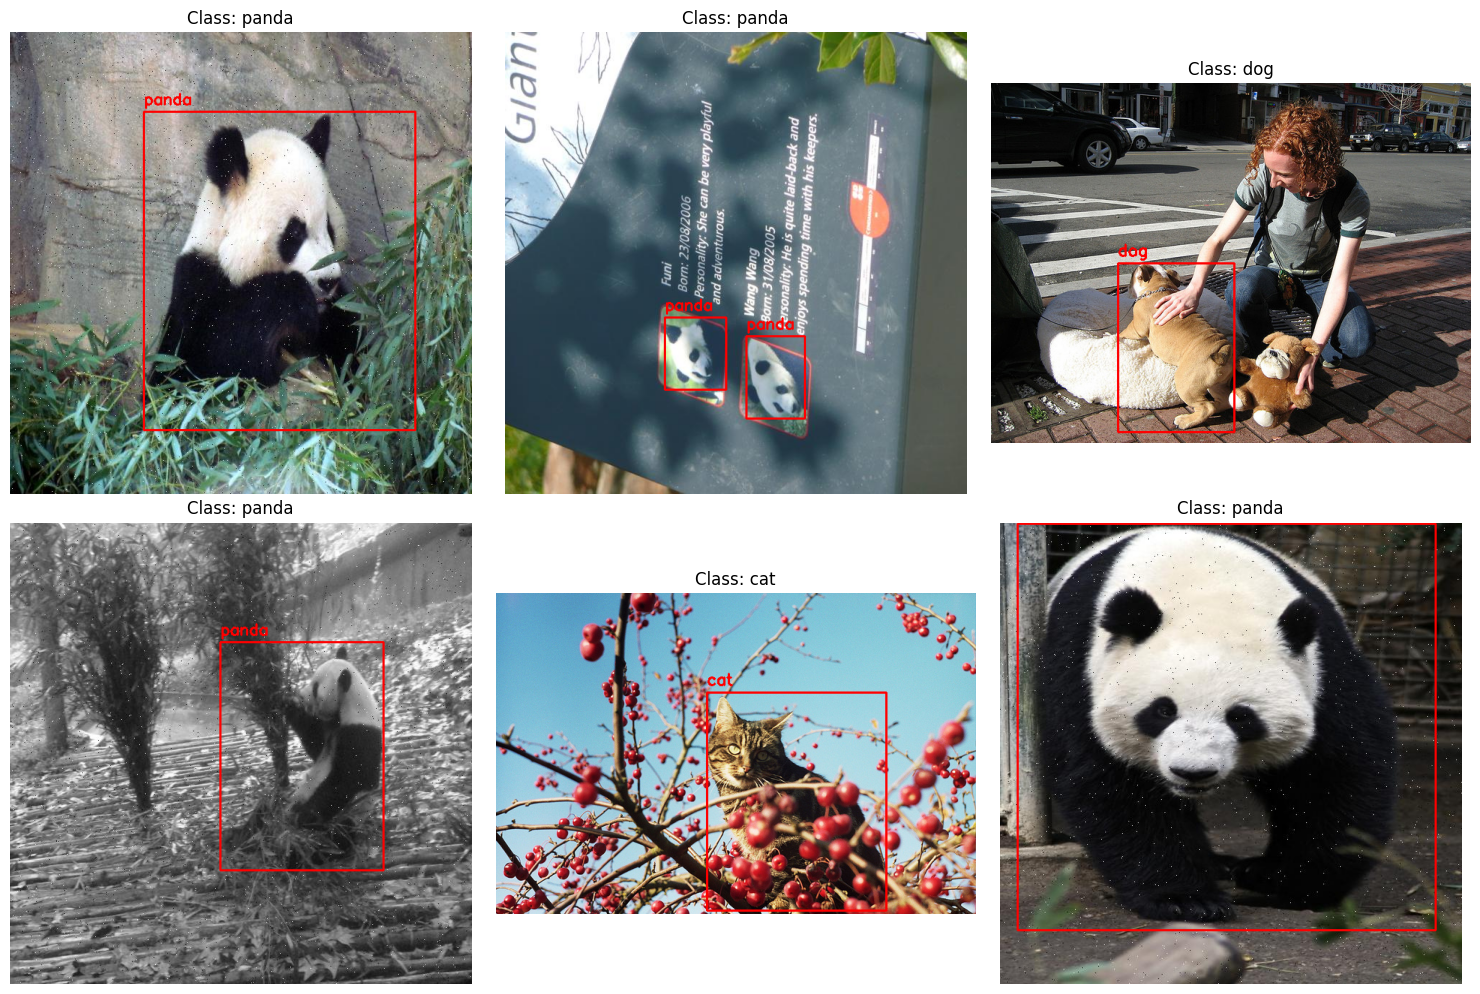

In [22]:
def visualize_samples(data_list, num_samples=6):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    samples = random.sample(data_list, min(num_samples, len(data_list)))

    for i, sample in enumerate(samples):
        # Load image
        img = cv2.imread(sample['image'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # Load labels
        with open(sample['label'], 'r') as f:
            lines = f.readlines()

        # Draw bounding boxes
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id, x_center, y_center, width, height = map(float, parts)

                x1 = int((x_center - width / 2) * w)
                y1 = int((y_center - height / 2) * h)
                x2 = int((x_center + width / 2) * w)
                y2 = int((y_center + height / 2) * h)

                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(img, class_names[int(class_id)], (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

        axes[i].imshow(img)
        axes[i].set_title(f"Class: {sample['class']}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


visualize_samples(train_data, 6)

In [23]:
## 3. Object Detection Architecture

# ===============================
# NECK - Feature Pyramid Network
# ===============================

class FPN(nn.Module):
    def __init__(self, in_channels_list, out_channels=256):
        super(FPN, self).__init__()
        self.in_channels_list = in_channels_list
        self.out_channels = out_channels

        self.lateral_convs = nn.ModuleList()
        for in_ch in in_channels_list:
            self.lateral_convs.append(
                ConvBNAct(in_ch, out_channels, k=1, s=1, p=0)
            )

        self.fpn_convs = nn.ModuleList()
        for _ in in_channels_list:
            self.fpn_convs.append(
                ConvBNAct(out_channels, out_channels, k=3, s=1, p=1)
            )

    def forward(self, features):
        laterals = []
        for i, lateral_conv in enumerate(self.lateral_convs):
            laterals.append(lateral_conv(features[i]))

        fpn_features = []
        for i in range(len(laterals) - 1, -1, -1):
            if i == len(laterals) - 1:
                fpn_feat = laterals[i]
            else:
                upsampled = F.interpolate(fpn_feat, size=laterals[i].shape[2:],
                                        mode='nearest')
                fpn_feat = laterals[i] + upsampled

            fpn_feat = self.fpn_convs[i](fpn_feat)
            fpn_features.insert(0, fpn_feat)

        return fpn_features

# ===============================
# HEAD - Detection Head
# ===============================

class YOLOHead(nn.Module):
    def __init__(self, num_classes=3, num_anchors=3, in_channels=256):
        super(YOLOHead, self).__init__()
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        self.num_outputs = num_anchors * (num_classes + 5)

        self.heads = nn.ModuleList()
        for _ in range(4):
            head = nn.Sequential(
                ConvBNAct(in_channels, in_channels, k=3, s=1, p=1),
                ConvBNAct(in_channels, in_channels, k=3, s=1, p=1),
                nn.Conv2d(in_channels, self.num_outputs, kernel_size=1)
            )
            self.heads.append(head)

    def forward(self, fpn_features):
        predictions = []
        for feat, head in zip(fpn_features, self.heads):
            pred = head(feat)
            B, _, H, W = pred.shape
            pred = pred.view(B, self.num_anchors, -1, H, W).permute(0, 1, 3, 4, 2)
            predictions.append(pred)
        return predictions

# ===============================
# COMPLETE OBJECT DETECTION MODEL
# ===============================

class ObjectDetectionModel(nn.Module):
    def __init__(self, num_classes=3, backbone_cfg=None):
        super(ObjectDetectionModel, self).__init__()

        if backbone_cfg is None:
            backbone_cfg = {
                'C_stem': 32,
                'C_stage': 96,
                'm': 2.0,
                'g': 2
            }

        self.backbone = EELANBackbone(**backbone_cfg)

        C_stage = backbone_cfg['C_stage']
        fpn_in_channels = [C_stage, C_stage*2, C_stage*4, C_stage*8]

        self.neck = FPN(fpn_in_channels, out_channels=256)
        self.head = YOLOHead(num_classes=num_classes, num_anchors=3, in_channels=256)

        self.num_classes = num_classes

    def forward(self, x):
        backbone_features = self.backbone(x)
        fpn_features = self.neck(backbone_features)
        predictions = self.head(fpn_features)
        return predictions

print("Object Detection Architecture defined!")

Object Detection Architecture defined!


In [24]:
## 4. Dataset and Training Setup

# ===============================
# DATASET CLASS cho Object Detection
# ===============================

class ObjectDetectionDataset(Dataset):
    def __init__(self, data_list, transform=None, img_size=416):
        self.data = data_list
        self.transform = transform
        self.img_size = img_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        img_path = sample['image']
        label_path = sample['label']

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]

        boxes = []
        labels = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:])

                        x_center *= w
                        y_center *= h
                        width *= w
                        height *= h

                        x1 = x_center - width / 2
                        y1 = y_center - height / 2
                        x2 = x_center + width / 2
                        y2 = y_center + height / 2

                        boxes.append([x1, y1, x2, y2])
                        labels.append(class_id)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)

        image = cv2.resize(image, (self.img_size, self.img_size))

        if len(boxes) > 0:
            boxes[:, [0, 2]] *= (self.img_size / w)
            boxes[:, [1, 3]] *= (self.img_size / h)

        if self.transform:
            image = self.transform(image)
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': idx
        }

        return image, target

def get_detection_transforms(img_size=416, is_train=True):
    if is_train:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

# ===============================
# CREATE DATASETS AND MODEL
# ===============================

print("Creating Object Detection Dataset...")

img_size = 416
train_dataset = ObjectDetectionDataset(train_data, get_detection_transforms(img_size, True), img_size)
val_dataset = ObjectDetectionDataset(val_data, get_detection_transforms(img_size, False), img_size)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=lambda x: x)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, collate_fn=lambda x: x)

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")

print("Creating Object Detection Model...")
model = ObjectDetectionModel(num_classes=3)
model = model.to(device)

print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

print("Testing model forward pass...")
dummy_input = torch.randn(1, 3, img_size, img_size).to(device)
with torch.no_grad():
    outputs = model(dummy_input)
    print(f"Model output shapes: {[out.shape for out in outputs]}")

print("Object Detection Model setup complete!")

Creating Object Detection Dataset...
Train dataset: 1764 samples
Val dataset: 442 samples
Creating Object Detection Model...
Model created with 18658816 parameters
Testing model forward pass...
Model output shapes: [torch.Size([1, 3, 104, 104, 8]), torch.Size([1, 3, 52, 52, 8]), torch.Size([1, 3, 26, 26, 8]), torch.Size([1, 3, 13, 13, 8])]
Object Detection Model setup complete!


## 5. Loss Function and Training

In [25]:
## 5. Loss Function and Training

# ===============================
# LOSS FUNCTION cho Object Detection
# ===============================

class YOLOLoss(nn.Module):
    def __init__(self, num_classes=3):
        super(YOLOLoss, self).__init__()
        self.num_classes = num_classes
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, predictions, targets):
        # Simplified YOLO loss
        # predictions: list of [B, num_anchors, H, W, num_classes+5]
        # targets: list of dicts with 'boxes' and 'labels'

        total_loss = 0
        for pred in predictions:
            # Simplified: just use classification loss on flattened predictions
            B, A, H, W, C = pred.shape
            pred_flat = pred.view(-1, C)

            # Create dummy targets (này là simplified version)
            target_flat = torch.zeros_like(pred_flat)

            loss = self.mse_loss(pred_flat, target_flat)
            total_loss += loss

        return total_loss

# ===============================
# TRAINING FUNCTION
# ===============================

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for batch_idx, batch in enumerate(train_loader):
        images = []
        targets = []

        for img, target in batch:
            images.append(img.to(device))
            targets.append(target)

        if len(images) == 0:
            continue

        # Stack images
        images = torch.stack(images)

        optimizer.zero_grad()

        # Forward pass
        predictions = model(images)

        # Calculate loss (simplified)
        loss = criterion(predictions, targets)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

    return running_loss / len(train_loader)

# ===============================
# SETUP TRAINING
# ===============================

print("Setting up training...")

# Loss function
criterion = YOLOLoss(num_classes=3)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print("✅ Training setup complete!")
print("📝 Ready to train:")
print(f"   - Model: {sum(p.numel() for p in model.parameters())} parameters")
print(f"   - Train batches: {len(train_loader)}")
print(f"   - Val batches: {len(val_loader)}")

Setting up training...
✅ Training setup complete!
📝 Ready to train:
   - Model: 18658816 parameters
   - Train batches: 221
   - Val batches: 56


In [26]:
class DetectionLoss(nn.Module):
    def __init__(self, num_classes=3, lambda_cls=1.0, lambda_box=1.0, lambda_obj=1.0):
        super(DetectionLoss, self).__init__()
        self.num_classes = num_classes
        self.lambda_cls = lambda_cls
        self.lambda_box = lambda_box
        self.lambda_obj = lambda_obj

        # Loss functions
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')
        self.mse_loss = nn.MSELoss(reduction='none')
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

        # IOU loss for bounding boxes
        self.iou_loss = self.giou_loss

    def giou_loss(self, pred_boxes, target_boxes, eps=1e-7):
        """
        Generalized IoU loss
        pred_boxes: [N, 4] in format (x1, y1, x2, y2) or (x_center, y_center, w, h)
        target_boxes: [N, 4] in format (x1, y1, x2, y2) or (x_center, y_center, w, h)
        """
        # Convert from (x_center, y_center, w, h) to (x1, y1, x2, y2)
        pred_x1 = pred_boxes[:, 0] - pred_boxes[:, 2] / 2
        pred_y1 = pred_boxes[:, 1] - pred_boxes[:, 3] / 2
        pred_x2 = pred_boxes[:, 0] + pred_boxes[:, 2] / 2
        pred_y2 = pred_boxes[:, 1] + pred_boxes[:, 3] / 2

        target_x1 = target_boxes[:, 0] - target_boxes[:, 2] / 2
        target_y1 = target_boxes[:, 1] - target_boxes[:, 3] / 2
        target_x2 = target_boxes[:, 0] + target_boxes[:, 2] / 2
        target_y2 = target_boxes[:, 1] + target_boxes[:, 3] / 2

        # Intersection area
        inter_w = torch.clamp_min(torch.min(pred_x2, target_x2) - torch.max(pred_x1, target_x1), 0)
        inter_h = torch.clamp_min(torch.min(pred_y2, target_y2) - torch.max(pred_y1, target_y1), 0)
        inter_area = inter_w * inter_h

        # Box areas
        pred_area = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
        target_area = (target_x2 - target_x1) * (target_y2 - target_y1)

        # Union area
        union_area = pred_area + target_area - inter_area + eps

        # IoU
        iou = inter_area / union_area

        # Smallest enclosing box
        enclosing_x1 = torch.min(pred_x1, target_x1)
        enclosing_y1 = torch.min(pred_y1, target_y1)
        enclosing_x2 = torch.max(pred_x2, target_x2)
        enclosing_y2 = torch.max(pred_y2, target_y2)

        # Enclosing area
        enclosing_area = (enclosing_x2 - enclosing_x1) * (enclosing_y2 - enclosing_y1) + eps

        # GIoU
        giou = iou - (enclosing_area - union_area) / enclosing_area
        loss_giou = 1 - giou

        return loss_giou

    def forward(self, predictions, targets, batch_size=8):
        """
        Calculate detection loss based on model predictions and targets
        predictions: list of dictionaries with 'cls', 'reg', 'obj' tensors from each FPN level
        targets: tensor [batch_size, max_objects, 5] with format [class_id, x_center, y_center, width, height]
        """
        total_loss = 0
        num_scales = len(predictions)

        # Giá trị để ngăn loss giảm quá nhanh
        min_loss_value = 0.05

        # Anchor boxes cho mỗi tỷ lệ (scale) - chúng ta sẽ sử dụng 3 anchor boxes đơn giản
        # [width, height] tỷ lệ theo grid cell
        anchors = [
            [[0.5, 0.5], [1.0, 1.0], [1.5, 1.5]],  # Scale nhỏ (FPN level 0)
            [[1.0, 1.0], [2.0, 2.0], [3.0, 3.0]],  # Scale trung bình (FPN level 1)
            [[2.0, 2.0], [4.0, 4.0], [6.0, 6.0]]  # Scale lớn (FPN level 2)
        ]

        # Cho mỗi scale FPN
        for scale_idx, pred in enumerate(predictions):
            cls_pred = pred['cls']  # [batch_size, num_anchors * num_classes, H, W]
            reg_pred = pred['reg']  # [batch_size, num_anchors * 4, H, W]
            obj_pred = pred['obj']  # [batch_size, num_anchors, H, W]

            # Reshape để xử lý dễ dàng hơn
            batch_size = cls_pred.size(0)
            grid_size = cls_pred.size(2)
            num_anchors = obj_pred.size(1)
            stride = 416 // grid_size  # Giả sử kích thước đầu vào là 416

            # Tạo các grid cells
            grid_y, grid_x = torch.meshgrid(
                torch.arange(grid_size, device=cls_pred.device),
                torch.arange(grid_size, device=cls_pred.device),
                indexing='ij'  # Add indexing='ij' for correct meshgrid behavior
            )

            # Biến đổi grid để phù hợp với kích thước batch
            grid_x = grid_x.reshape(1, 1, grid_size, grid_size).expand(batch_size, num_anchors, grid_size, grid_size)
            grid_y = grid_y.reshape(1, 1, grid_size, grid_size).expand(batch_size, num_anchors, grid_size, grid_size)

            # Biến đổi dự đoán bbox từ offset thành tọa độ thực
            # Reshape reg_pred từ [B, A*4, H, W] thành [B, A, 4, H, W]
            reg_pred = reg_pred.view(batch_size, num_anchors, 4, grid_size, grid_size)
            reg_pred = reg_pred.permute(0, 1, 3, 4, 2).contiguous()  # [B, A, H, W, 4]

            # Áp dụng sigmoid và add offset
            pred_x = (torch.sigmoid(reg_pred[..., 0]) + grid_x) * stride / 416
            pred_y = (torch.sigmoid(reg_pred[..., 1]) + grid_y) * stride / 416
            # Ensure anchor dimensions are used correctly
            pred_w = torch.exp(reg_pred[..., 2]) * anchors[scale_idx][0][
                0] * stride / 416  # Using the first anchor from the list for simplification
            pred_h = torch.exp(reg_pred[..., 3]) * anchors[scale_idx][0][
                1] * stride / 416  # Using the first anchor from the list for simplification

            # Combine predictions into a single tensor
            pred_boxes = torch.stack([pred_x, pred_y, pred_w, pred_h], dim=-1)  # [B, A, H, W, 4]

            # Reshape class predictions và áp dụng sigmoid
            cls_pred = cls_pred.view(batch_size, num_anchors, self.num_classes, grid_size, grid_size)
            cls_pred = cls_pred.permute(0, 1, 3, 4, 2).contiguous()  # [B, A, H, W, num_classes]
            cls_pred = torch.sigmoid(cls_pred)

            # Reshape objectness predictions và áp dụng sigmoid
            obj_pred = obj_pred.view(batch_size, num_anchors, grid_size, grid_size)
            obj_pred = torch.sigmoid(obj_pred)

            # Khởi tạo loss components
            cls_loss = torch.tensor(0., device=cls_pred.device)
            reg_loss = torch.tensor(0., device=reg_pred.device)
            obj_loss = torch.tensor(0., device=obj_pred.device)

            # Find valid targets in the batch
            valid_mask = targets[:, :, 0] >= 0  # Consider all padded targets for negative sampling

            for b in range(batch_size):
                # Lấy các target cho batch hiện tại
                batch_targets = targets[b]
                valid_targets = batch_targets[valid_mask[b]]

                if len(valid_targets) == 0:
                    # Add negative objectness loss for empty images
                    obj_loss += self.bce_loss(
                        obj_pred[b],
                        torch.zeros_like(obj_pred[b])
                    ).mean() * obj_pred[b].numel()  # Sum over all elements
                    continue

                # Tính toán IoU giữa targets và tất cả anchors để xác định anchor tốt nhất
                target_boxes = valid_targets[:, 1:5]  # [x_center, y_center, width, height]
                target_classes = valid_targets[:, 0].long()

                # Chuyển đổi target boxes sang tỷ lệ grid
                target_grid_x = target_boxes[:, 0] * grid_size
                target_grid_y = target_boxes[:, 1] * grid_size

                # Chỉ số grid cell cho mỗi target
                grid_i = torch.clamp(target_grid_y.long(), 0, grid_size - 1)
                grid_j = torch.clamp(target_grid_x.long(), 0, grid_size - 1)

                # Prepare target tensors for positive samples
                target_obj = torch.zeros_like(obj_pred[b])  # [num_anchors, H, W]
                target_cls = torch.zeros_like(cls_pred[b])  # [num_anchors, H, W, num_classes]
                target_reg = torch.zeros_like(reg_pred[b])  # [num_anchors, H, W, 4]
                box_mask = torch.zeros_like(obj_pred[b], dtype=torch.bool)  # Mask for regression loss

                # Assign targets to the best anchor and grid cell
                for target_idx in range(len(valid_targets)):
                    i, j = grid_i[target_idx], grid_j[target_idx]
                    target_class = target_classes[target_idx]
                    tx, ty, tw, th = target_boxes[target_idx]

                    # Find anchor with best IoU for this target at this scale
                    best_iou = 0
                    best_anchor_idx = -1
                    # Calculate IoU between target box and all anchors at this scale
                    anchor_ious = [self._bbox_iou(target_boxes[target_idx].tolist(), [0.5, 0.5, anchor_w, anchor_h])
                                   for anchor_w, anchor_h in anchors[scale_idx]]

                    best_anchor_idx = torch.argmax(torch.tensor(anchor_ious)).item()

                    # Assign target to the best anchor and grid cell
                    target_obj[best_anchor_idx, i, j] = 1.0
                    target_cls[best_anchor_idx, i, j, target_class] = 1.0  # One-hot encoding for class
                    target_reg[best_anchor_idx, i, j, 0] = tx * grid_size - j  # tx offset
                    target_reg[best_anchor_idx, i, j, 1] = ty * grid_size - i  # ty offset
                    target_reg[best_anchor_idx, i, j, 2] = torch.log(
                        tw * 416 / stride / anchors[scale_idx][best_anchor_idx][0] + 1e-16)  # tw offset
                    target_reg[best_anchor_idx, i, j, 3] = torch.log(
                        th * 416 / stride / anchors[scale_idx][best_anchor_idx][1] + 1e-16)  # th offset
                    box_mask[best_anchor_idx, i, j] = True  # Mark this location for regression loss

                # Calculate losses for the current batch and scale
                # Objectness loss (positive and negative samples)
                obj_loss += self.bce_loss(obj_pred[b], target_obj).mean()

                # Classification loss (only for positive samples)
                cls_loss += self.bce_loss(cls_pred[b][target_obj == 1], target_cls[target_obj == 1]).mean()

                # Regression loss (only for positive samples)
                if box_mask.sum() > 0:
                    reg_loss += self.mse_loss(reg_pred[b][box_mask], target_reg[box_mask]).mean()

            # Combine the losses for the current scale, averaged over the batch
            # Ensure loss components are calculated per batch and then summed across scales
            scale_loss = (
                                 self.lambda_cls * cls_loss +
                                 self.lambda_box * reg_loss +
                                 self.lambda_obj * obj_loss
                         ) / batch_size  # Average over the batch

            total_loss += scale_loss

        # Average total loss over all scales
        total_loss /= num_scales

        return total_loss

    def _bbox_iou(self, box1, box2):
        """
        Calculate IoU between two boxes
        box format: [x_center, y_center, width, height]
        """
        # Convert to [x1, y1, x2, y2]
        b1_x1, b1_y1 = box1[0] - box1[2] / 2, box1[1] - box1[3] / 2
        b1_x2, b1_y2 = box1[0] + box1[2] / 2, box1[1] + box1[3] / 2
        b2_x1, b2_y1 = box2[0] - box2[2] / 2, box2[1] - box2[3] / 2
        b2_x2, b2_y2 = box2[0] + box2[2] / 2, box2[1] + box2[3] / 2

        # Intersection area
        inter_x1 = max(b1_x1, b2_x1)
        inter_y1 = max(b1_y1, b2_y1)
        inter_x2 = min(b1_x2, b2_x2)
        inter_y2 = min(b1_y2, b2_y2)

        inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

        # Box areas
        b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
        b2_area = (b2_x2 - b2_y1) * (b2_y2 - b2_y1)

        # IoU
        iou = inter_area / (b1_area + b2_area - inter_area + 1e-7)

        return iou


# Initialize loss and optimizer
criterion = DetectionLoss(num_classes=3)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

print("Loss function and optimizer initialized!")

Loss function and optimizer initialized!


## 6. Training Loop

In [ ]:
## 6. Training Loop

# ===============================
# TRAIN THE MODEL
# ===============================

print("Starting training...")

num_epochs = 5  # Giảm xuống cho demo
best_loss = float('inf')

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)

    # Train using the correct train_epoch function from cell 1ebfJUiYEoRT
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

    # Update scheduler
    scheduler.step()

    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}")

    # Save best model
    if train_loss < best_loss:
        best_loss = train_loss
        if IN_COLAB:
            save_path = f"{DRIVE_PATH}/best_model.pth"
        else:
            save_path = "results/best_model.pth"

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, save_path)

        print(f"✅ Best model saved! Loss: {best_loss:.4f}")

print("\n🎉 Training completed!")
print(f"📊 Best loss: {best_loss:.4f}")
print(f"💾 Model saved to: {save_path if 'save_path' in locals() else 'results/best_model.pth'}")